This Jupyter Python Notebook can be used to reproduce the findings presented in *Weiss et al. 2023* and can serve as the basis for the exploration of phenotypic profiling data that is provided in a "tidy" tabular format. The experimental methodology used to obtain the presented sample data set are described in the manuscript.

The notebook performs
- Loading data from two 384-well plates of a phenotypic profiling experiment (Plate 1 and Plate 2) present in a single .fth file
- Feature scaling per plate
- Plotting of individual features of choice to explore the data
- Unsupervised phenotypic profile analysis: 1) Plotting of phenotypic profiles as a Cosine distance-clustered heatmap, 2) UMAP and PaCMAP dimensionalty reduction for visualization
- Supervised phenotypic profile analysis: 1) Training of a LightGBM classifier on data from Plate 1, 2) Application of the trained LightGBM model on data from Plate 2  

To sucessfully run the notebook use the two provided files and store them in the same root directory as the Jupyter Python Notebook:
- requirements.txt (to install all required packages)
- Raw_mDANeuron_phenotypic_features.fth (contains the data from Plate 1 and Plate 2


# Install required packages

In [16]:
# ATTENTION: For reproducibility purposes only. Risk of package downgrading. 
# If needed, run the provided "requirements.txt" file to install the version of the packages that was used to generate the presented analysis.

#!pip install -r requirements.txt

# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import umap
import pacmap
import lightgbm as lgb

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

import joblib
from statannotations.Annotator import Annotator

# Specify the input and output paths and load the data

In [2]:
# To reproduce the analysis, indicate your local path to the provided "Raw_mDANeuron_phenotypic_features.fth" file and specify an output path to save the plots

# Input file
input_file = 'Raw_mDANeuron_phenotypic_features.fth'
# Output path
saving_path = 'Results/'

# Load data
df = pd.read_feather(input_file)



## Scale phenotypic feature data per plate

In [12]:
# Define a function to standardize the numeric columns per category
def standardize_numeric(df):
    # Group the dataframe by the "Plate" column
    groups = df.groupby("Plate")
    numeric_cols = df.select_dtypes(include=["number"]).columns
    # Loop through the groups and standardize the numeric columns
    res={}
    for name, group in groups:
        print(group['Plate'].unique())        
        scaler = RobustScaler()        
        df.loc[group.index, numeric_cols] = scaler.fit_transform(group[numeric_cols])
    return df

# Copy data prior to standardisation
df_unscaled = df.copy(deep=True)

# Call the function to standardize the numeric columns per category
df_scaled = standardize_numeric(df)

['Plate 1']
['Plate 2']


# Compare features of choice from both plates before and after scaling

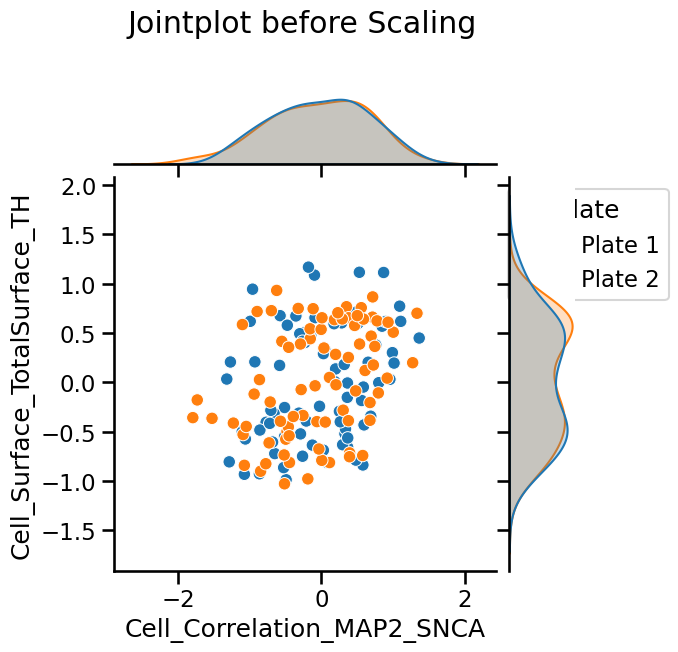

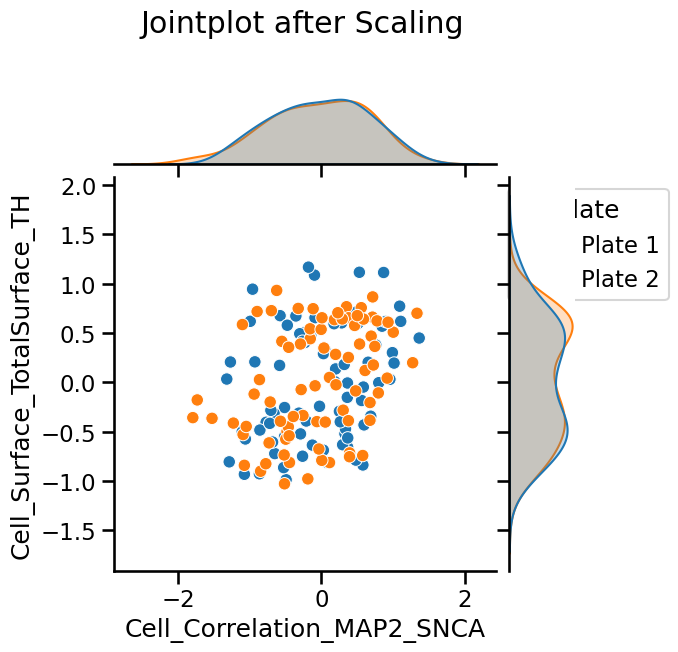

In [13]:
# Plot data before and after scaling
g = sns.jointplot(data=df_unscaled, 
              x="Cell_Correlation_MAP2_SNCA", 
              y="Cell_Surface_TotalSurface_TH", 
              hue='Plate')
plt.suptitle("Jointplot before Scaling", y=1.1)
sns.move_legend(g.ax_joint, "upper left", bbox_to_anchor=(1, 1))
plt.show()

g = sns.jointplot(data=df_scaled, 
              x="Cell_Correlation_MAP2_SNCA", 
              y="Cell_Surface_TotalSurface_TH", 
              hue='Plate')
plt.suptitle("Jointplot after Scaling", y=1.1)
sns.move_legend(g.ax_joint, "upper left", bbox_to_anchor=(1, 1))
plt.show()

## Data cleaning

In [10]:
# Update df to scaled data
df = df_scaled

# Get df info before wrangling
print(df.info())

# Get column names
df_cols = df.columns

# Remove inf and NaN
pd.options.mode.use_inf_as_na = True
df.dropna(axis=1, inplace=True)
pd.options.mode.use_inf_as_na = False

# Print 10 random rows
print(df.loc[:, ["Plate", "tags"]].sample(n=10))

# Data with updated plate names
df_Plate = df.copy()

# Sort alphabetically
df_Plate = df_Plate.sort_values('tags')

# Specifically for LightGBM to work with integer categories
# Encode cell line name as integer
# Create a dictionary to map the categorical variables to integers
cat_to_int = {
    'WT (Fujifilm)': 0, 
    'WT (Fujifilm) 0.1µM PFE-360': 1,
    'LRRK2 (Fujifilm)': 2,
    'LRRK2 (Fujifilm) 0.1µM PFE-360': 3
    }
# Create a new column 'Cell line' with the encoded integers
df_Plate['Cell line'] = df_Plate['tags'].map(cat_to_int)

plates=df_Plate.unique()

# Plate 1
df_Plate_1 = df_Plate[df_Plate["Plate"] == "Plate 1"]
print(df_Plate_1.shape[1])
# Plate 2
df_Plate_2 = df_Plate[df_Plate["Plate"] == "Plate 2"]

# Select numerical cols
df_Plate_numeric = df_Plate.select_dtypes(include=np.number)
df_Plate_1_numeric = df_Plate_1.select_dtypes(include=np.number)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Columns: 129 entries, Well to Nuclei_Surface_MeanArea
dtypes: float32(126), object(3)
memory usage: 82.6+ KB
None
       Plate                            tags
73   Plate 1  LRRK2 (Fujifilm) 0.1µM PFE-360
109  Plate 2                   WT (Fujifilm)
63   Plate 1                LRRK2 (Fujifilm)
26   Plate 1                   WT (Fujifilm)
88   Plate 2                   WT (Fujifilm)
151  Plate 2  LRRK2 (Fujifilm) 0.1µM PFE-360
127  Plate 2                LRRK2 (Fujifilm)
98   Plate 2                   WT (Fujifilm)
67   Plate 1                LRRK2 (Fujifilm)
92   Plate 2                   WT (Fujifilm)
130


# Plot single feature

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
d:\Python310\lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

WT (Fujifilm) vs. WT (Fujifilm) 0.1µM PFE-360: Welch's t-test independent samples, P_val:7.744e-06 t=5.964e+00
LRRK2 (Fujifilm) vs. LRRK2 (Fujifilm) 0.1µM PFE-360: Welch's t-test independent samples, P_val:1.953e-03 t=3.779e+00
WT (Fujifilm) vs. LRRK2 (Fujifilm): Welch's t-test independent samples, P_val:6.942e-12 t=-8.584e+00


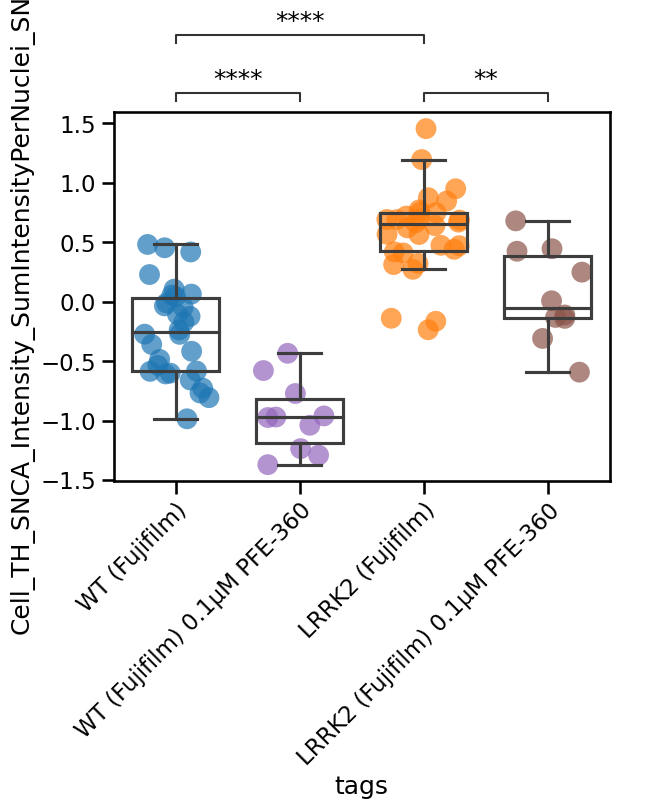

In [11]:
# Plot parameters
data=df_Plate_1
data_cols = pd.DataFrame({'Columns': data.columns})  
x='tags'
y="Cell_TH_SNCA_Intensity_SumIntensityPerNuclei_SNCA" #"Cell_TH_SNCA_Intensity_SumIntensityPerNuclei_SNCA", "Cell_Neurites_LengthPerNuclei_MAP2", "Nuclei_Living_Ratio_TH"
hue='Plate'
order = ['WT (Fujifilm)', 'WT (Fujifilm) 0.1µM PFE-360',
         'LRRK2 (Fujifilm)', 'LRRK2 (Fujifilm) 0.1µM PFE-360']
palette = {'WT (Fujifilm)': 'C0', 
           'WT (Fujifilm) 0.1µM PFE-360': 'C4',
           'LRRK2 (Fujifilm)': 'C1',
           'LRRK2 (Fujifilm) 0.1µM PFE-360': 'C5'}
stat_pairs=[("WT (Fujifilm)", "LRRK2 (Fujifilm)"), 
            ("WT (Fujifilm)", 'WT (Fujifilm) 0.1µM PFE-360'), 
            ("LRRK2 (Fujifilm)", 'LRRK2 (Fujifilm) 0.1µM PFE-360')]

# Plot design
sns.set_context("talk", font_scale=1.0)

# Create boxplot
ax = sns.boxplot(x=x, y=y, data=data, 
                 width=0.7, showfliers=False, 
                 order=order, zorder=1, dodge=True)
# Transparancy of boxplot filling color
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0))

# Create stripplot
ax = sns.stripplot(x=x, y=y, data=data, 
                   jitter=0.3, size=15, alpha=0.7, 
                   zorder=0, order=order, 
                   palette=palette)

# Create the legend and remove the frame and title
legend = plt.legend(frameon=False, title=None)

# Move legend outside of plot
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Rotate tickmarks
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

# Add statistical annotations
annotator = Annotator(ax, stat_pairs, data=data, x=x, y=y, order=order)
annotator.configure(test='t-test_welch', text_format='star', loc='outside')
annotator.apply_and_annotate()

# Show plot and save
plt.savefig(saving_path + y + '.pdf', bbox_inches='tight')
plt.show()

# Clustered heatmap of all features

In [15]:
df_Plate_1_numeric.columns

Index(['Cell_Correlation_MAP2_SNCA', 'Cell_Correlation_TH_SNCA',
       'Cell_Correlation_VanSteelselsMeanX_TH_SNCA',
       'Cell_Correlation_VanSteelselsMeanY_TH_SNCA',
       'Cell_Correlation_VanSteelselsSigmaX_TH_SNCA',
       'Cell_Correlation_VanSteelselsSigmaY_TH_SNCA',
       'Cell_Intensity_MeanIntensity_MAP2',
       'Cell_Intensity_MeanIntensity_SNCA', 'Cell_Intensity_MeanIntensity_TH',
       'Cell_Intensity_SumIntensityPerNuclei_SNCA',
       ...
       'Nuclei_Number_Living', 'Nuclei_Number_MAP2', 'Nuclei_Number_MAP2_SNCA',
       'Nuclei_Number_SNCA', 'Nuclei_Number_TH', 'Nuclei_Number_TH_SNCA',
       'Nuclei_Ratio_Dead', 'Nuclei_Ratio_Living', 'Nuclei_Surface_MeanArea',
       'Cell line'],
      dtype='object', length=127)

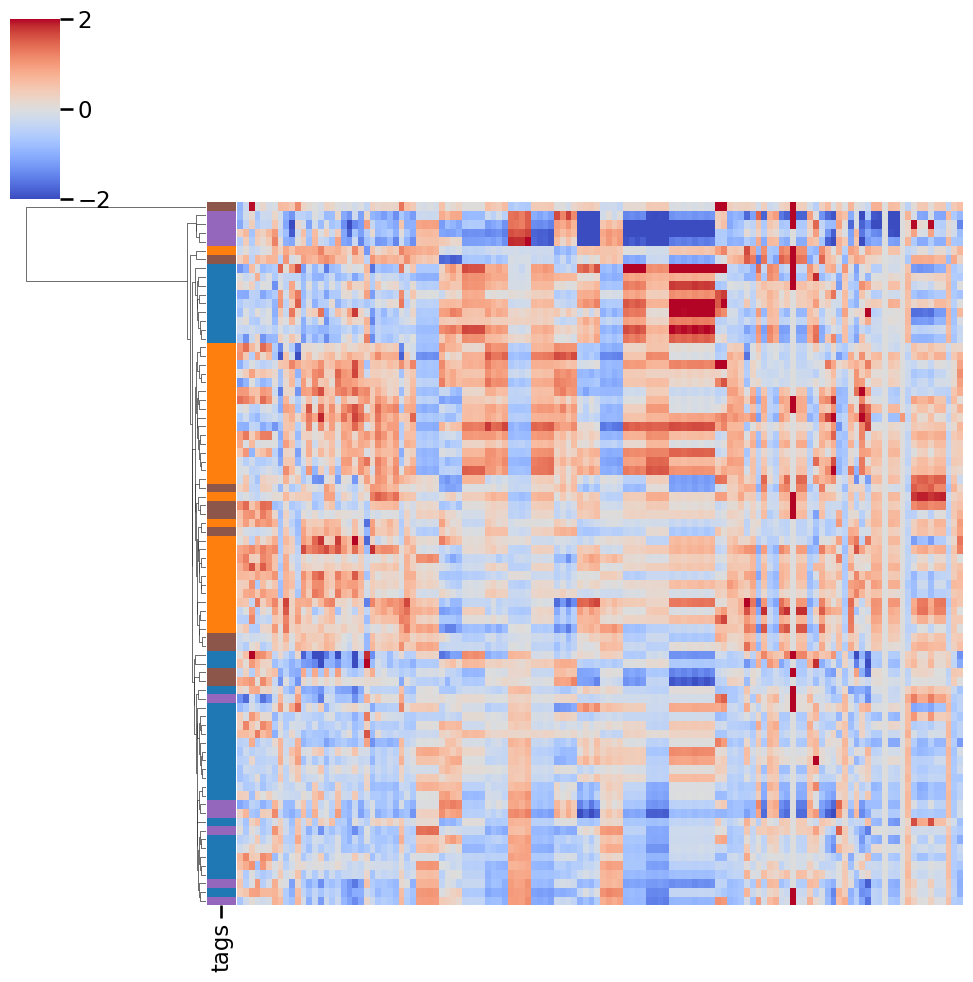

In [16]:
# Drop 'Cell line column"
df_Plate_1_numeric_red = df_Plate_1_numeric.drop(columns='Cell line')

# Define the color map to be used for the "tags" column
row_colors = df_Plate["tags"].map({'WT (Fujifilm)': 'C0', 
                                   'WT (Fujifilm) 0.1µM PFE-360': 'C4',
                                   'LRRK2 (Fujifilm)': 'C1',
                                   'LRRK2 (Fujifilm) 0.1µM PFE-360': 'C5'
                                   })

# Plot design
sns.set_context("talk", font_scale=1.0)

# Plot all groups as heatmap
ax = sns.clustermap(df_Plate_1_numeric_red, yticklabels=False, xticklabels=False, 
                    vmin=-2, vmax=2, cmap='coolwarm',
                    col_cluster=False, row_colors=row_colors,
                    metric='cosine'
                    )
plt.savefig(saving_path + 'heatmap' + '.pdf', bbox_inches='tight')
plt.show()


## UMAP

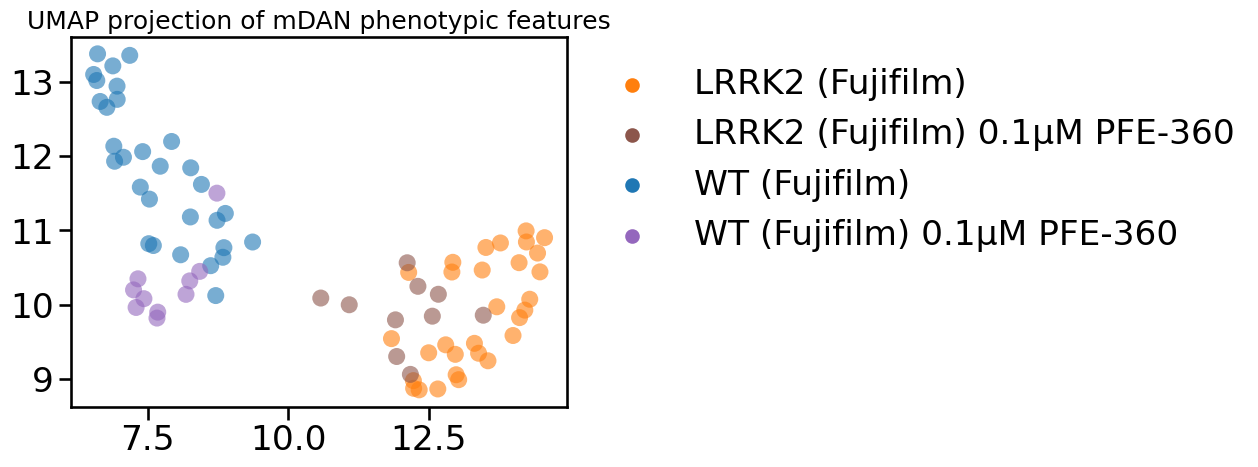

In [11]:
# UMAP
reduce_umap = umap.UMAP()

# Train the reducer to create embedding
embedding_umap = reduce_umap.fit_transform(df_Plate_1_numeric_red)

# Plot design
sns.set_context("talk", font_scale=1.0)

# Plot embedding as scatterplot
ax = sns.scatterplot(
    x=embedding_umap[:, 0],
    y=embedding_umap[:, 1],
    hue=df_Plate_1.tags, 
    s=150,
    linewidth=0,
    palette=palette,
    alpha=0.6)

plt.title('UMAP projection of mDAN phenotypic features', fontsize=18)

leg = ax.legend(frameon=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig(saving_path + 'umap' + '.pdf', bbox_inches='tight')
plt.show()


## PaCMAP

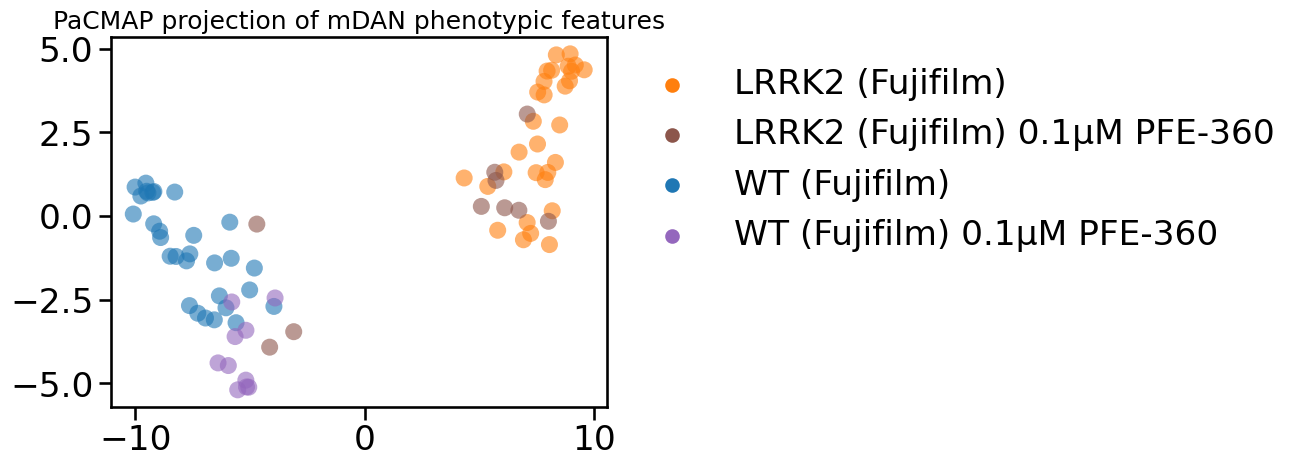

In [12]:
# PaCMAP
reducer_pacmap = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.5) 

# Train the reducer to create embedding
embedding_pacmap = reducer_pacmap.fit_transform(df_Plate_1_numeric_red, init="random")

# Plot design
sns.set_context("talk", font_scale=1.0)

# Plot embedding as scatterplot
ax = sns.scatterplot(
    x=embedding_pacmap[:, 0],
    y=embedding_pacmap[:, 1],
    hue=df_Plate_1.tags,
    s=150,
    linewidth=0,
    palette=palette,
    alpha=0.6)

plt.title('PaCMAP projection of mDAN phenotypic features', fontsize=18)

leg = ax.legend(frameon=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig(saving_path + 'pacmap' + '.pdf', bbox_inches='tight')
plt.show()

In [13]:
# If necessary visually appealing paramters for PaCMAP embedding can be chosen here by iteration

# # Define the range of values for MN_ratio and FP_ratio
# MN_ratios = [0.5, 1.0, 1.5]
# FP_ratios = [2.5, 3.0, 3.5]

# # Iterate over all combinations of MN_ratio and FP_ratio
# for MN_ratio in MN_ratios:
#     for FP_ratio in FP_ratios:
#         # Create the reducer and train it on the data
#         reducer_pacmap = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=MN_ratio, FP_ratio=FP_ratio)
#         embedding_pacmap = reducer_pacmap.fit_transform(df_Plate_numeric_red, init="random")
        
#         # Create the scatterplot and save it to a file
#         ax = sns.scatterplot(x=embedding_pacmap[:, 0], 
#                              y=embedding_pacmap[:, 1], 
#                              hue=df_Plate.tags)
#         plt.title('PaCMAP projection of mDAN phenotypic features (MN_ratio={}, FP_ratio={})'.format(MN_ratio, FP_ratio), fontsize=18)
#         leg = ax.legend(frameon=False)
#         sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#         #plt.savefig(saving_path + 'pacmap_MN{}_FP{}'.format(MN_ratio, FP_ratio) + '.pdf', bbox_inches='tight')
#         plt.show()

## Supervised classification

### Train classifier on Plate 1 data

Best Hyperparameters: {'classifier__colsample_bytree': 0.5, 'classifier__learning_rate': 0.3, 'classifier__max_depth': 3, 'classifier__num_leaves': 10}


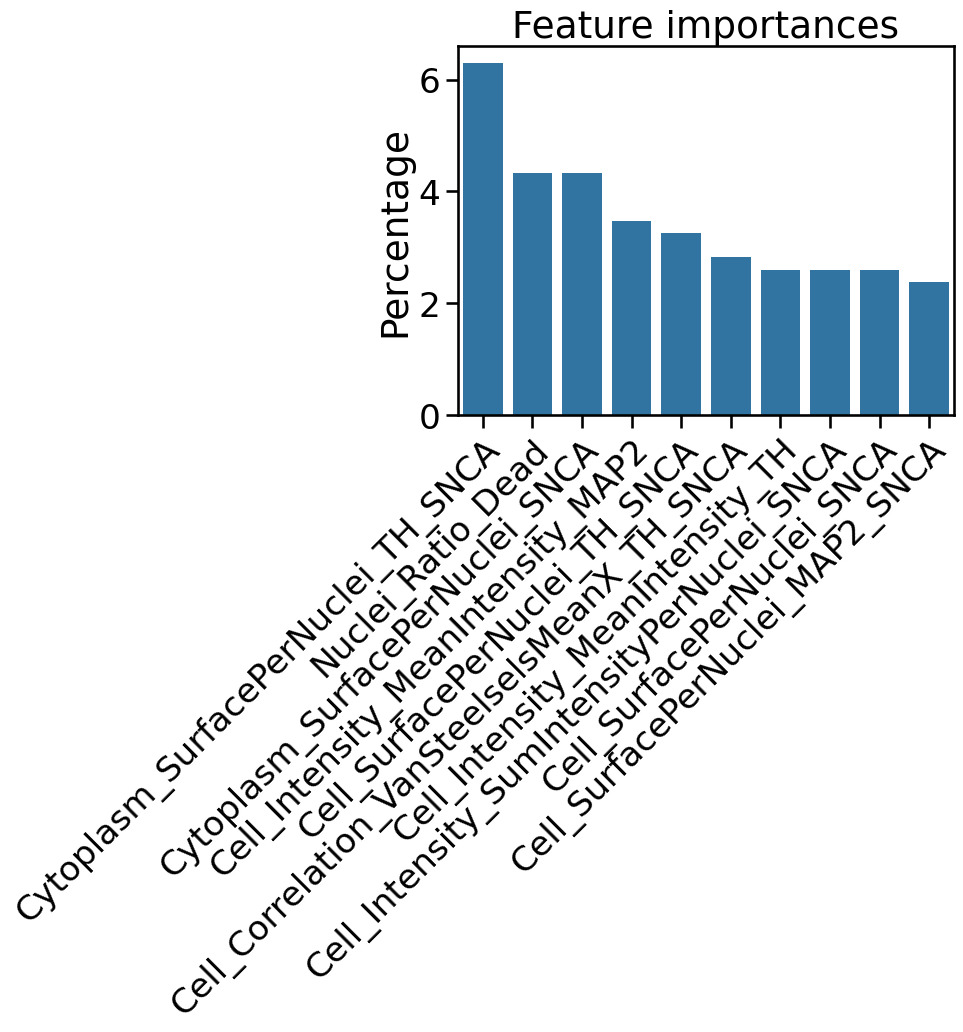

    Cell line  True Cell Line  Pred Cell Line  Prob Class 0  Prob Class 1  \
21          0               0               0      0.999914  8.319843e-05   
58          2               2               2      0.000001  1.599008e-07   
44          2               2               2      0.000008  3.308390e-07   
18          0               0               0      0.999985  1.401387e-05   

    Prob Class 2  Prob Class 3  
21  9.774071e-07  1.964796e-06  
58  9.998322e-01  1.666148e-04  
44  9.999907e-01  7.859351e-07  
18  6.534373e-07  9.538437e-08  
Accuracy: 1.0


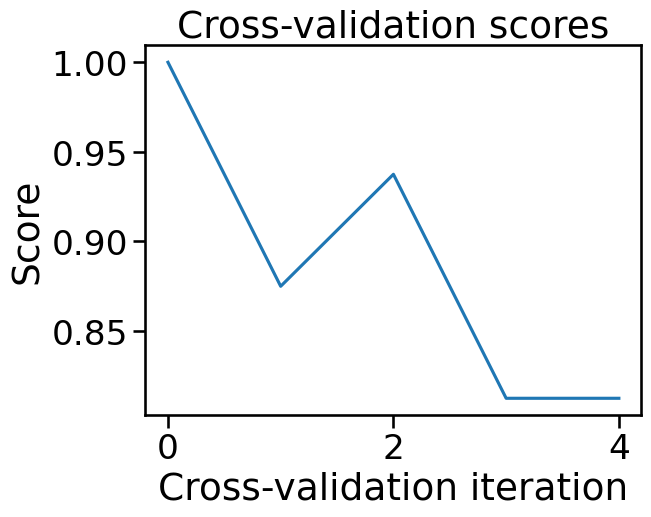

In [14]:
# PREPARE DATA FOR LEARNING
df = df_Plate_1
target_col = 'Cell line'

# OPTIONAL: Exclude columns of a certain feature type i.e. "Texture"
#df = df.filter(regex='^(?!.*Texture)')

# Split the data into features and target
X = df.drop(columns=[target_col]).select_dtypes(include=[np.number])
y = df[target_col]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, 
                                                    random_state=42, stratify=y)

# PREPROCESSING & CLASSIFICATION

# Create the pipeline for preprocessing and classification
pipeline = Pipeline([
    ('classifier', lgb.LGBMClassifier())
])

# Define the hyperparameter search space
param_grid = {'classifier__num_leaves': [2, 3, 10, 20],
              'classifier__max_depth': [1, 2, 3, 5, 7],
              'classifier__learning_rate': [0.1, 0.2, 0.3],
              'classifier__colsample_bytree': [0.5, 0.7, 0.9, 1.0]
              }

# Use grid search cross-validation to find the best hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

# Train the pipeline on the full training set with the best hyperparameters
pipeline.set_params(**grid_search.best_params_)
pipeline.fit(X_train, y_train)

# Save the pipeline 
joblib.dump(pipeline, saving_path + 'classifier_pipeline.joblib')

# Plot design
sns.set_context("talk", font_scale=1.0)

# Get and plot feature importances
def plot_feature_importances(model, feature_names, top_n):
    model = model.named_steps["classifier"]

    importances = model.booster_.feature_importance()
    importances_percent = importances / np.sum(importances) * 100
    indices = np.argsort(importances)[::-1][:top_n]
    sns.barplot(x=feature_names[indices], y=importances_percent[indices], color="C0")
    plt.title("Feature importances")
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
    plt.ylabel('Percentage')
    plt.savefig(saving_path + 'feature_importances' + '.pdf', bbox_inches='tight')
    plt.show()

plot_feature_importances(pipeline, X.columns, top_n=10)

# Make predictions on the test set and get the probabilities for each class
y_probs = pipeline.predict_proba(X_test)[:, :]
y_pred = pipeline.predict(X_test)

# Add the true condition labels to the results for comparison
results = pd.DataFrame({target_col: df.loc[X_test.index, target_col],
                        'True Cell Line': y_test,
                        'Pred Cell Line': y_pred})
results['Prob Class 0'] = y_probs[:, 0]
results['Prob Class 1'] = y_probs[:, 1]
results['Prob Class 2'] = y_probs[:, 2]
results['Prob Class 3'] = y_probs[:, 3]

print(results)

# Save results as table
results.to_csv(saving_path + 'Test_set_classification.csv')

# Evaluate the accuracy of the classifier on the test set
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Plot the cross-validation scores
scores = cross_val_score(pipeline, X, y, cv=5)
sns.lineplot(data=scores)
plt.xlabel("Cross-validation iteration")
plt.ylabel("Score")
plt.title("Cross-validation scores")
plt.show()

### Test trained classifier on unseen data from Plate 2

     Cell line  True Cell Line  Pred Cell Line  Prob Class 0  Prob Class 1  \
122          2               2               2  1.044016e-06  1.993114e-07   
125          2               2               2  8.154291e-06  3.024627e-05   
124          2               2               2  2.710411e-07  6.688696e-09   
123          2               2               2  5.647417e-07  5.237803e-08   
121          2               2               2  3.235034e-07  2.339324e-08   
..         ...             ...             ...           ...           ...   
115          1               1               1  1.248760e-01  8.750877e-01   
116          1               1               1  1.466709e-03  9.985185e-01   
118          1               1               1  2.800651e-01  6.332641e-01   
119          1               1               1  1.275671e-01  6.350534e-01   
117          1               1               1  1.380103e-01  8.566360e-01   

     Prob Class 2  Prob Class 3  
122      0.999998  8.190281e-

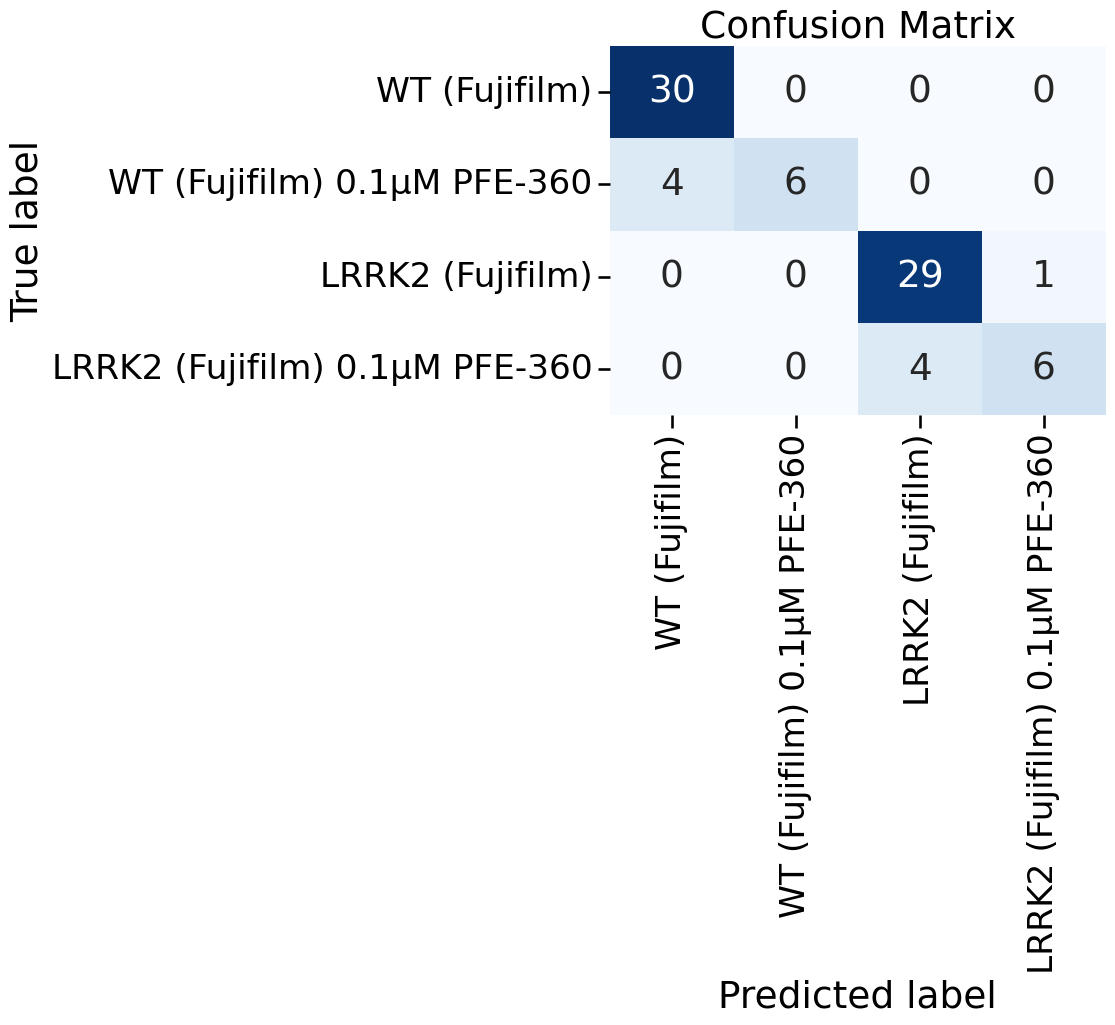

In [15]:
# PREPARE DATA FOR LEARNING
df2 = df_Plate_2
target_col = 'Cell line'

# OPTIONAL: Exclude columns of a certain feature type i.e. "Texture"
# df2 = df2.filter(regex='^(?!.*Texture)')

# Split the data into features and target
X_new = df2.drop(columns=[target_col]).select_dtypes(include=[np.number])
y_new = df2[target_col]

# Load the trained XGboost model pipeline
pipeline = joblib.load(saving_path + 'classifier_pipeline.joblib')

# Make predictions on the new data and get the probabilities of each sample belonging to the "Control" class
y_new_pred = pipeline.predict(X_new)
y_new_probs = pipeline.predict_proba(X_new)[:, :]

# Add the true condition labels to the results for comparison
results_new = pd.DataFrame({target_col: df2.loc[X_new.index, target_col],
                        'True Cell Line': y_new,
                        'Pred Cell Line': y_new_pred})
results_new['Prob Class 0'] = y_new_probs[:, 0]
results_new['Prob Class 1'] = y_new_probs[:, 1]
results_new['Prob Class 2'] = y_new_probs[:, 2]
results_new['Prob Class 3'] = y_new_probs[:, 3]

print(results_new)

# Save results as table
results_new.to_csv(saving_path + 'Validation_set_classification.csv')

# Evaluate the accuracy of the classifier on the test set
accuracy = accuracy_score(y_new, y_new_pred)
print('Accuracy:', accuracy)

# Create a confusion matrix plot to visualize the performance of the model
# Convert integer labels to string labels
y_new_true = y_new.map({v: k for k, v in cat_to_int.items()})
y_new_pred_str = pd.Series([list(cat_to_int.keys())[i] for i in y_new_pred])

# Plot design
sns.set_context("talk", font_scale=1.0)

# Create confusion matrix plot
cm = confusion_matrix(y_new_true, y_new_pred_str)
labels = list(cat_to_int.keys())

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig(saving_path + 'confusion_matrix' + '.pdf', bbox_inches='tight')
plt.show()